In [1]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
from skimage.io import imread
import scipy.io as sio
from epipolar_utils import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

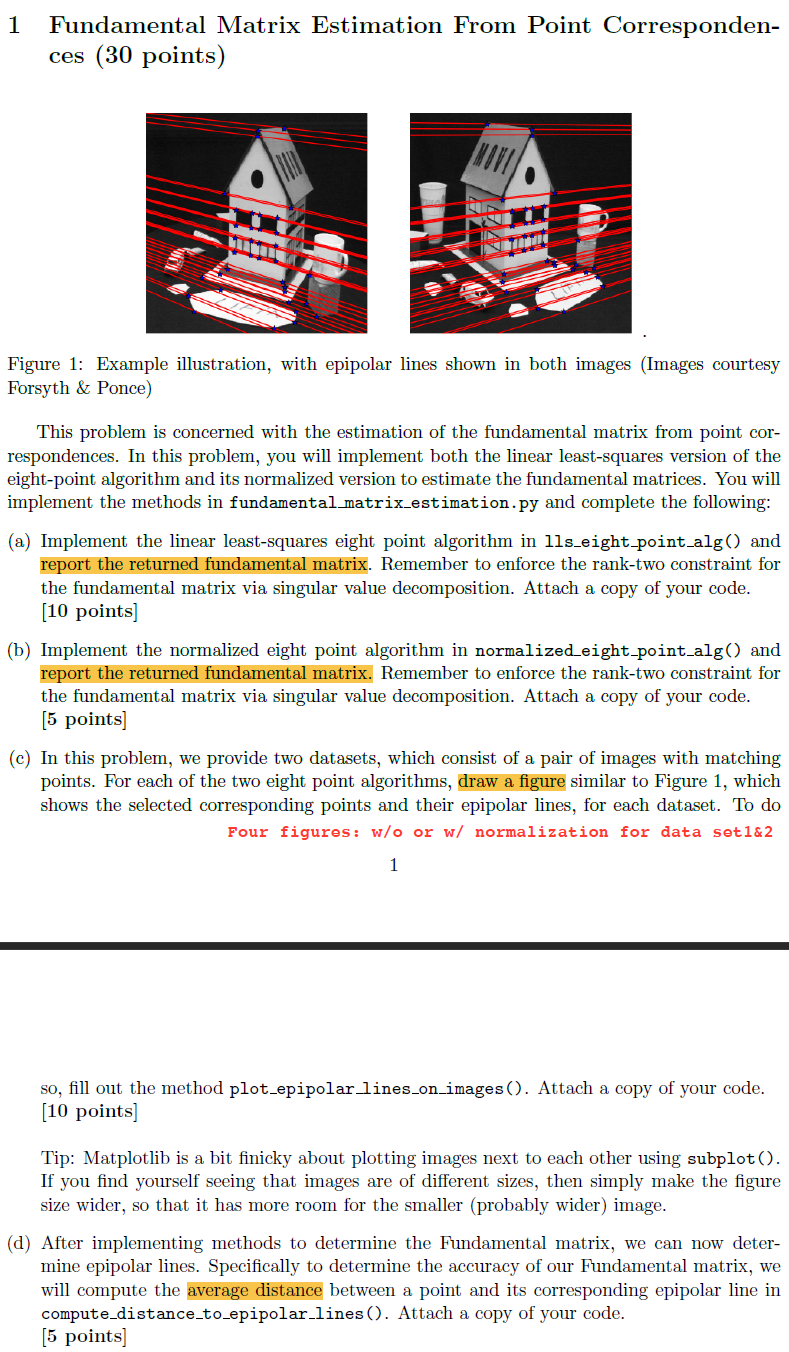

In [2]:
def compute_distance_to_epipolar_lines(points1, points2, F):
    '''
    COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a 
    points to their corresponding epipolar lines
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
        F - the fundamental matrix such that (points2)^T * F * points1 = 0

        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        average_distance - the average distance of each point to the epipolar line
    '''

    l = F.T.dot(points2.T)
    # distance from point(x0, y0) to line: Ax + By + C = 0 is
    # |Ax0 + By0 + C| / sqrt(A^2 + B^2)
    d = np.mean(np.abs(np.sum(l * points1.T, axis=0)) / np.sqrt(l[0, :] ** 2 + l[1, :] ** 2))
    return d

In [3]:
##(a)
def lls_eight_point_alg(points1, points2):
    '''
    LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
    linear least squares eight point algorithm
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1

        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
    Please see lecture notes and slides to see how the linear least squares eight
    point algorithm works
    '''
    # TODO: Implement this method!
    p_num = points1.shape[0]
    W = np.zeros((p_num, 9))
    for i in range(p_num):
        u1 = points1[i,0]
        v1 = points1[i,1]
        u2 = points2[i,0]
        v2 = points2[i,1] 
        W[i] = np.array([u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1, 1])
    U, s, vt = np.linalg.svd(W)
    F_hat = vt[-1,:].reshape((3,3))
    U1, s1, vt1 = np.linalg.svd(F_hat)
    s_f = np.zeros((3,3))
    s_f[0,0],s_f[1,1] = s1[0], s1[1]
    F = U1.dot(s_f).dot(vt1)
    return F

In [4]:
# Running the linear least squares eight point algorithm
for im_set in ['data/set1', 'data/set2']:
    
    print('-'*80)
    print("Set:", im_set)
    print('-'*80)

    # Read in the data
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)
    F_lls = lls_eight_point_alg(points1, points2)
    print("Fundamental Matrix from LLS  8-point algorithm:\n", F_lls)
    print("Distance to lines in image 1 for LLS:", \
        compute_distance_to_epipolar_lines(points1, points2, F_lls))
    print("Distance to lines in image 2 for LLS:", \
        compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
Fundamental Matrix from LLS  8-point algorithm:
 [[ 1.55218081e-06 -8.18161523e-06 -1.50440111e-03]
 [-5.86997052e-06 -3.02892219e-07 -1.13607605e-02]
 [-3.52312036e-03  1.41453881e-02  9.99828068e-01]]
Distance to lines in image 1 for LLS: 28.025662937501366
Distance to lines in image 2 for LLS: 25.162875800010667
--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
Fundamental Matrix from LLS  8-point algorithm:
 [[-5.63087200e-06  2.74976583e-05 -6.42650411e-03]
 [-2.77622828e-05 -6.74748522e-06  1.52182033e-02]
 [ 1.07623595e-02 -1.22519240e-02 -9.99730547e-01]]
Distance to lines in image 1 for LLS: 9.701438829445713
Distance to lines in image 2 for LLS: 14.568227190514486


In [5]:
##(b)
def normalized_eight_point_alg(points1, points2):
    '''
    NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
    using the normalized eight point algorithm
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
    Please see lecture notes and slides to see how the normalized eight
    point algorithm works
    '''
    
    p_num = points1.shape[0]
    points11 = points1[:, :2]
    points21 = points2[:, :2]

    # normalization
    mean1 = np.mean(points1, axis=0)
    T1 = np.array([[1, 0, -mean1[0]],
                   [0, 1, -mean1[1]],
                   [0, 0, 1]])
    scale1 = np.sqrt(2 / np.mean(np.sum((points1 - mean1) ** 2, axis=1)))
    S1 = np.array([[scale1,0,0],
                        [0,scale1,0],
                        [0,0,1]])
    ##Scaling.dot(Translation)
    ST1 = S1.dot(T1)
    p1T = ST1.dot(points1.T)
    q1=p1T.T

    mean2 = np.mean(points2, axis=0)
    T2 = np.array([[1, 0, -mean2[0]],
                   [0, 1, -mean2[1]],
                   [0, 0, 1]])
    scale2 = np.sqrt(2 / np.mean(np.sum((points2 - mean2) ** 2, axis=1)))
    S2 = np.array([[scale2,0,0],
                        [0,scale2,0],
                        [0,0,1]])
    ST2 = S2.dot(T2)
    p2T = ST2.dot(points2.T)
    q2=p2T.T
    Fq = lls_eight_point_alg(q1, q2)
    F = ST2.T.dot(Fq).dot(ST1)

    return F

In [6]:
# Running the normalized eight point algorithm
for im_set in ['data/set1', 'data/set2']:
    print('-'*80)
    print("Set:", im_set)
    print('-'*80)

    # Read in the data
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)
    F_normalized = normalized_eight_point_alg(points1, points2)
    pFp = [points2[i].dot(F_normalized.dot(points1[i])) 
    for i in range(points1.shape[0])]
    print("p'^T F p =", np.abs(pFp).max())
    print("Fundamental Matrix from normalized 8-point algorithm:\n", \
        F_normalized)
    print("Distance to lines in image 1 for normalized:", \
        compute_distance_to_epipolar_lines(points1, points2, F_normalized))
    print("Distance to lines in image 2 for normalized:", \
        compute_distance_to_epipolar_lines(points2, points1, F_normalized.T))

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
p'^T F p = 0.03029585331320961
Fundamental Matrix from normalized 8-point algorithm:
 [[ 6.52113484e-07 -5.33615067e-06  8.80860210e-05]
 [-4.91237449e-06 -3.40420428e-07 -6.43807393e-03]
 [-8.56136054e-04  8.84208000e-03  1.45953063e-01]]
Distance to lines in image 1 for normalized: 0.8906416272438451
Distance to lines in image 2 for normalized: 0.8287729118221452
--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
p'^T F p = 0.033136691062293444
Fundamental Matrix from normalized 8-point algorithm:
 [[-1.51007608e-07  2.51618737e-06 -1.56134009e-04]
 [ 3.63462620e-06  3.22311660e-07  7.02588719e-03]
 [ 2.36155133e-04 -8.53003408e-03 -2.45880925e-03]]
Distance to lines in image 1 for norm

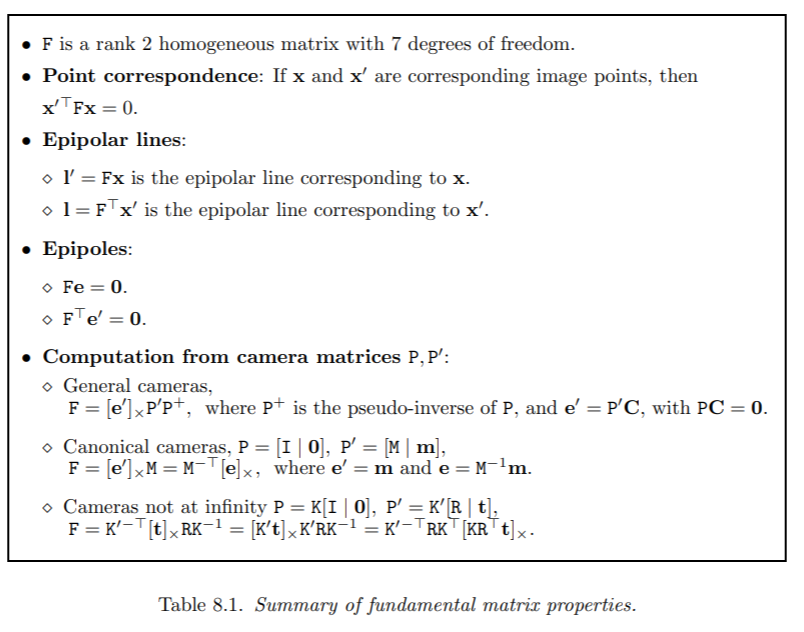
https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf

In [7]:
#(c)
def plot_epipolar_lines_on_images(points1, points2, im1, im2, F):
    '''
    PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
    draws the epipolar lines on the images
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
        im1 - a HxW(xC) matrix that contains pixel values from the first image 
        im2 - a HxW(xC) matrix that contains pixel values from the second image 
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        Nothing; instead, plots the two images with the matching points and
        their corresponding epipolar lines. See Figure 1 within the problem set
        handout for an example
    '''
    p_num = points1.shape[0]
    h1 = im1.shape[0]
    w1 = im1.shape[1]
    h2 = im2.shape[0]
    w2 = im2.shape[1]
    # l = F.T * p' is the epipolar line associated with p'
    # l' = F * p is the epipolar line associated with p
    l1 = F.T.dot(points2.T)
    l2 = F.dot(points1.T)
    plt.subplot(121)
    
    plt.imshow(im1, cmap='gray')
    for i in range(p_num):
        # l = [a, b, c] => ax + by + c = 0, y = -(a/b)x - c/b
        X1 = np.arange(0, w1, 1)
        Y = -(l1[0, i] / l1[1, i]) * X1 - (l1[2, i] / l1[1, i])
        idx = (Y >= 0) & (Y <= h1)
        X1 = X1[idx]
        Y = Y[idx]
        plt.plot(X1, Y, 'r')
        plt.plot(points1[i, 0], points1[i, 1], '*', color='b')
    plt.subplot(122)
    plt.imshow(im2, cmap='gray')
    for i in range(p_num):
        # l = [a, b, c] => ax + by + c = 0, y = -(a/b)x - c/b
        X2 = np.arange(0, w2, 1)
        Y = -(l2[0, i] / l2[1, i]) * X2 - (l2[2, i] / l2[1, i])
        idx = (Y >= 0) & (Y <= h2)
        X2 = X2[idx]
        Y = Y[idx]
        plt.plot(X2, Y, 'r')
        plt.plot(points2[i, 0], points2[i, 1], '*', color='b')

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------


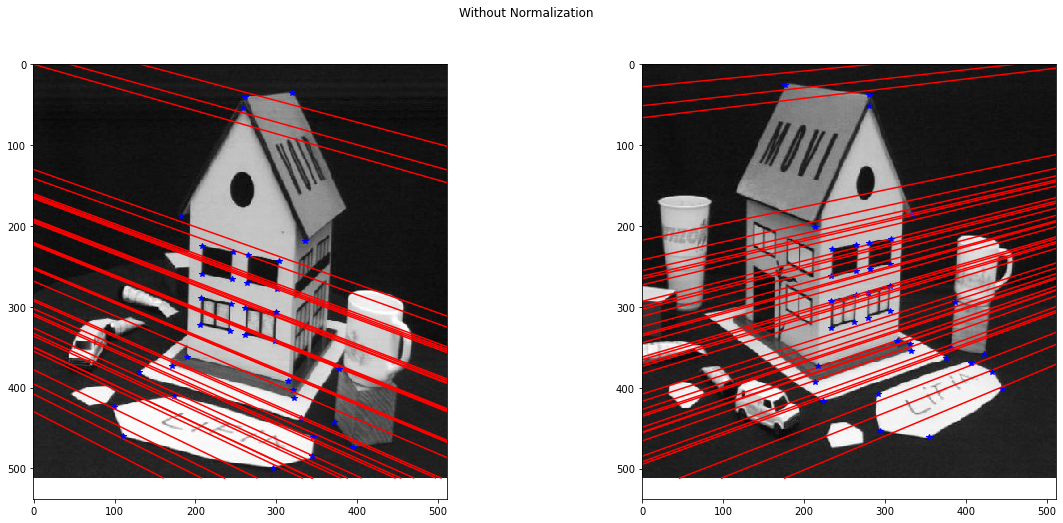

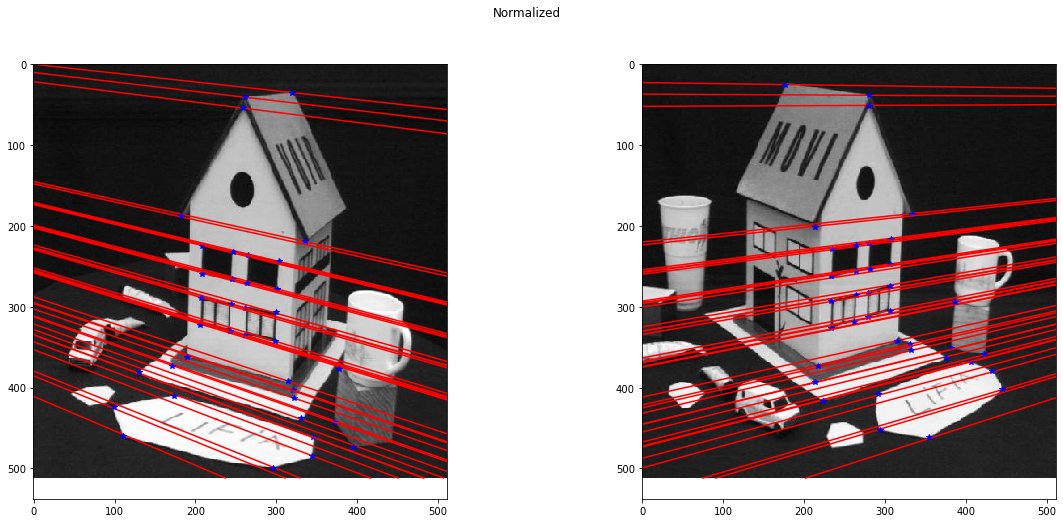

--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------


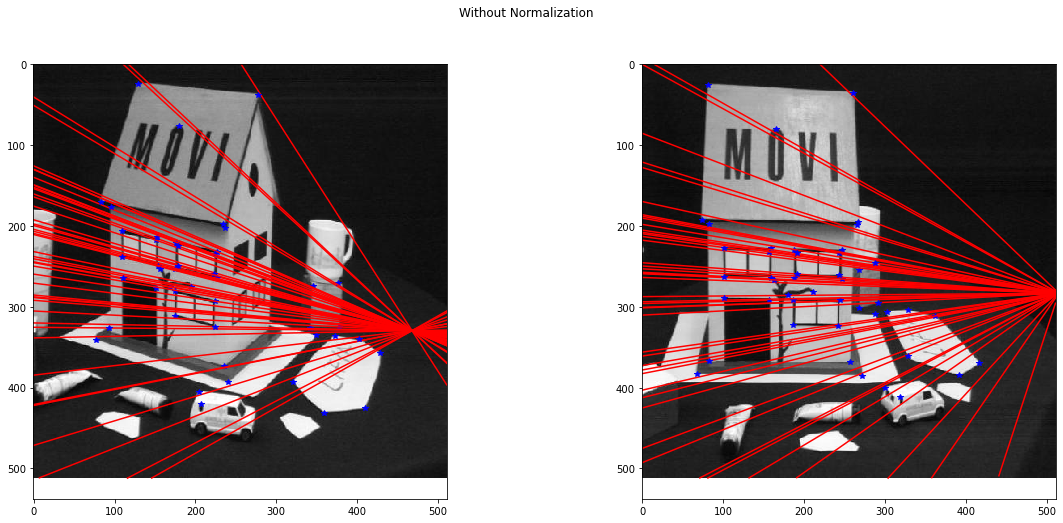

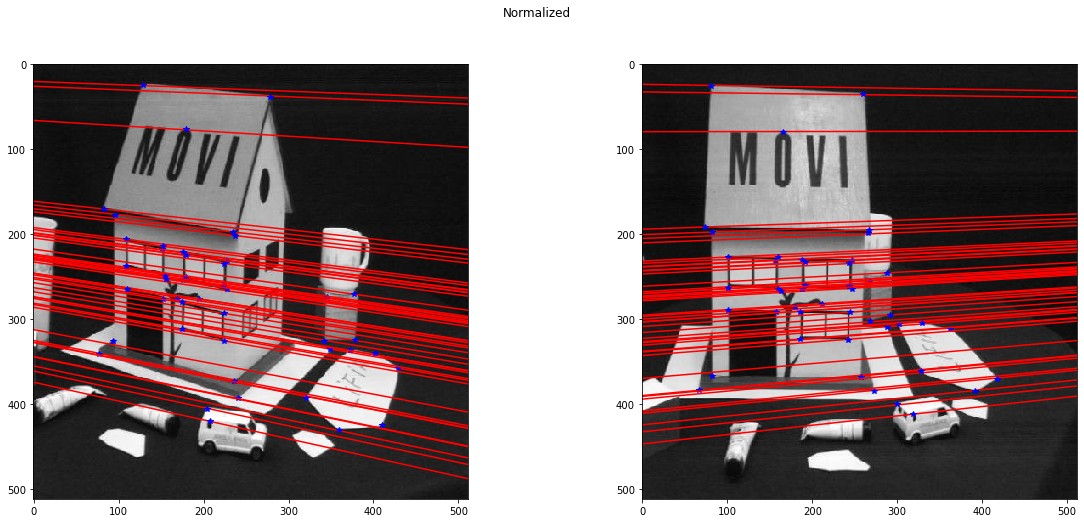

In [8]:
# Running the normalized eight point algorithm
for im_set in ['data/set1', 'data/set2']:
    print('-'*80)
    print("Set:", im_set)
    print('-'*80)

    # Read in the data
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)
    
    F_lls = lls_eight_point_alg(points1, points2)
    F_normalized = normalized_eight_point_alg(points1, points2)
    fig1 = plt.figure("Without Normalization",figsize=(20, 8))
    fig1.suptitle("Without Normalization")
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
    fig2 = plt.figure("Normalized",figsize=(20, 8))
    fig2.suptitle("Normalized")
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_normalized)

    plt.show()

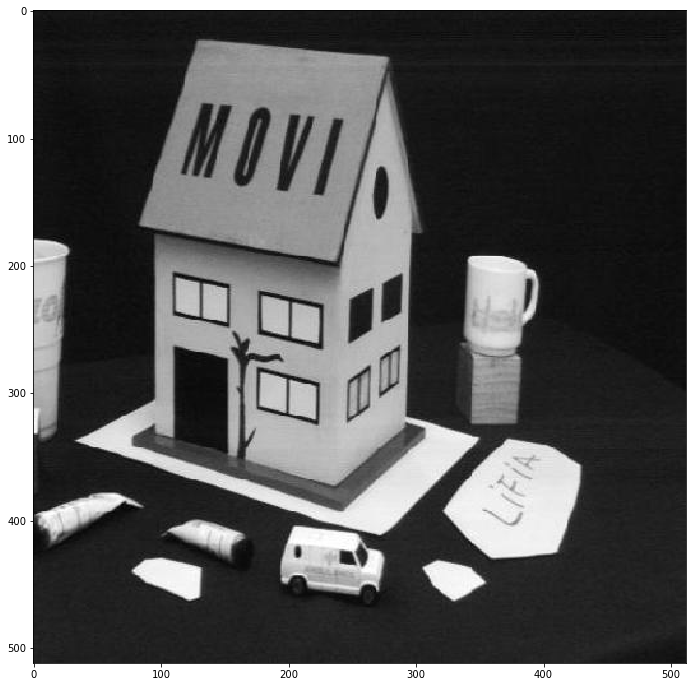

In [9]:
plt.figure("Without Normalization")
plt.imshow(im1, cmap='gray')
plt.show()

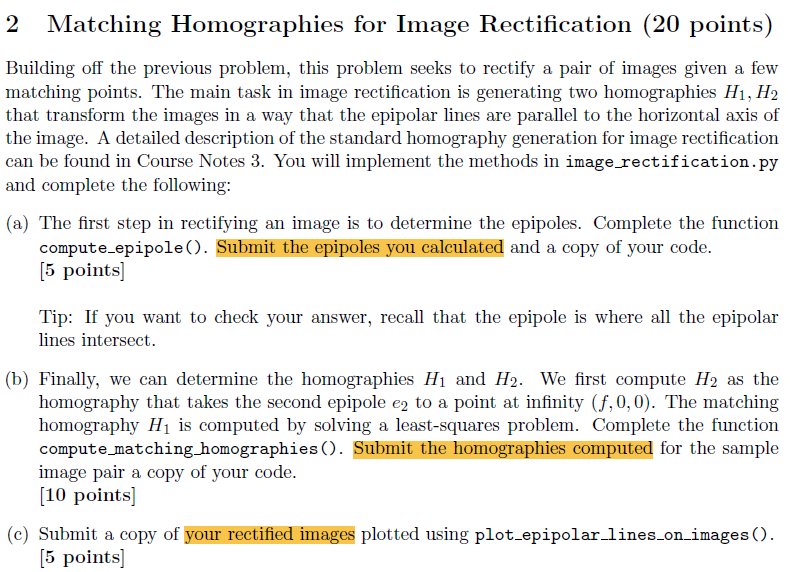

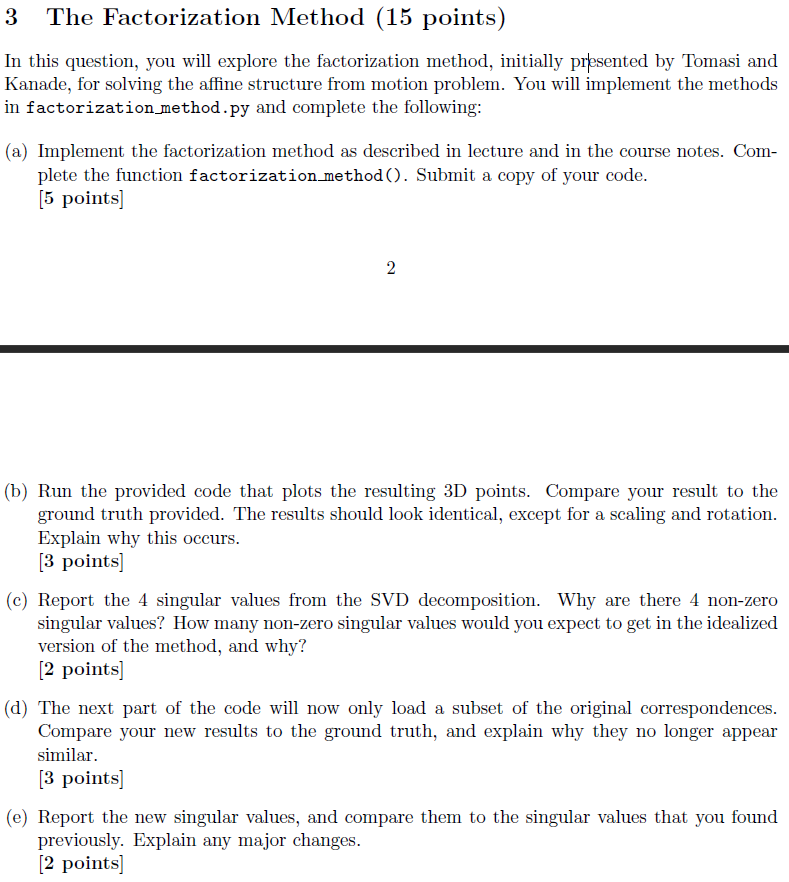

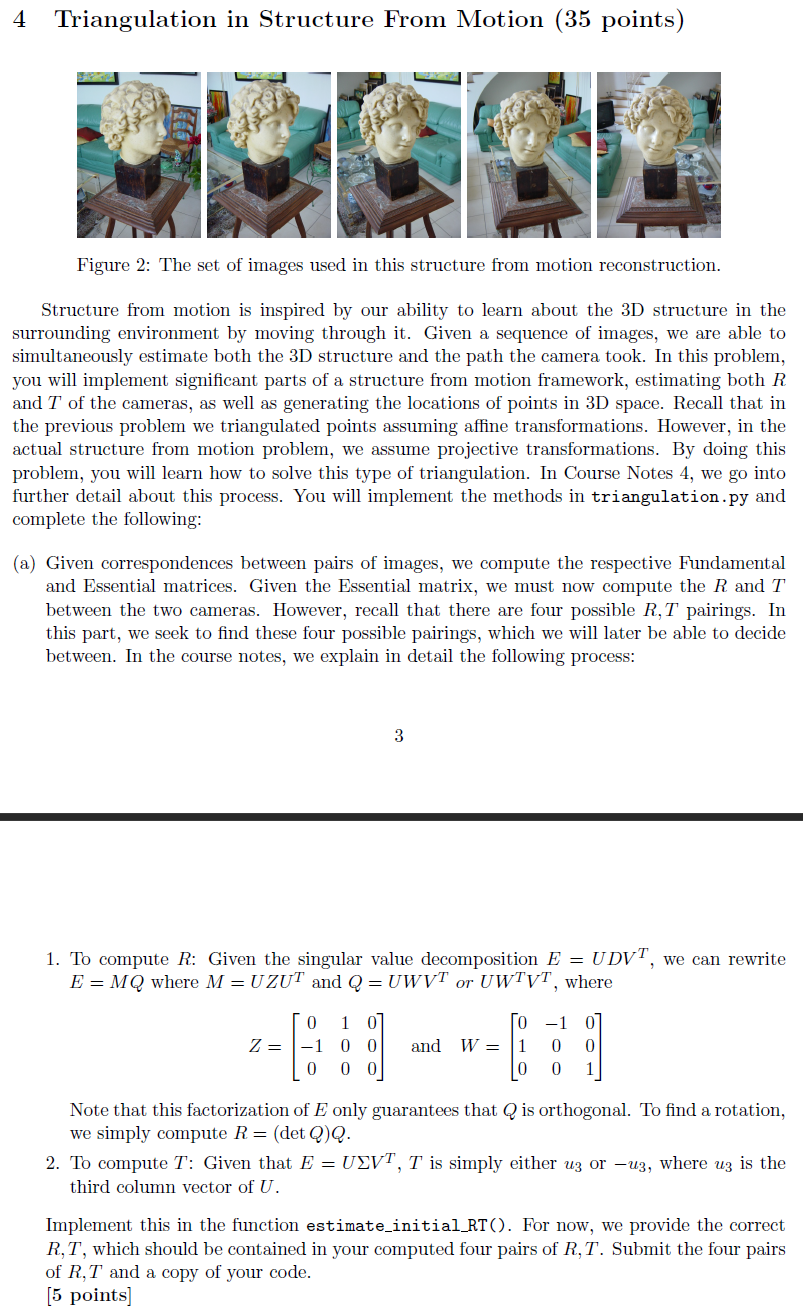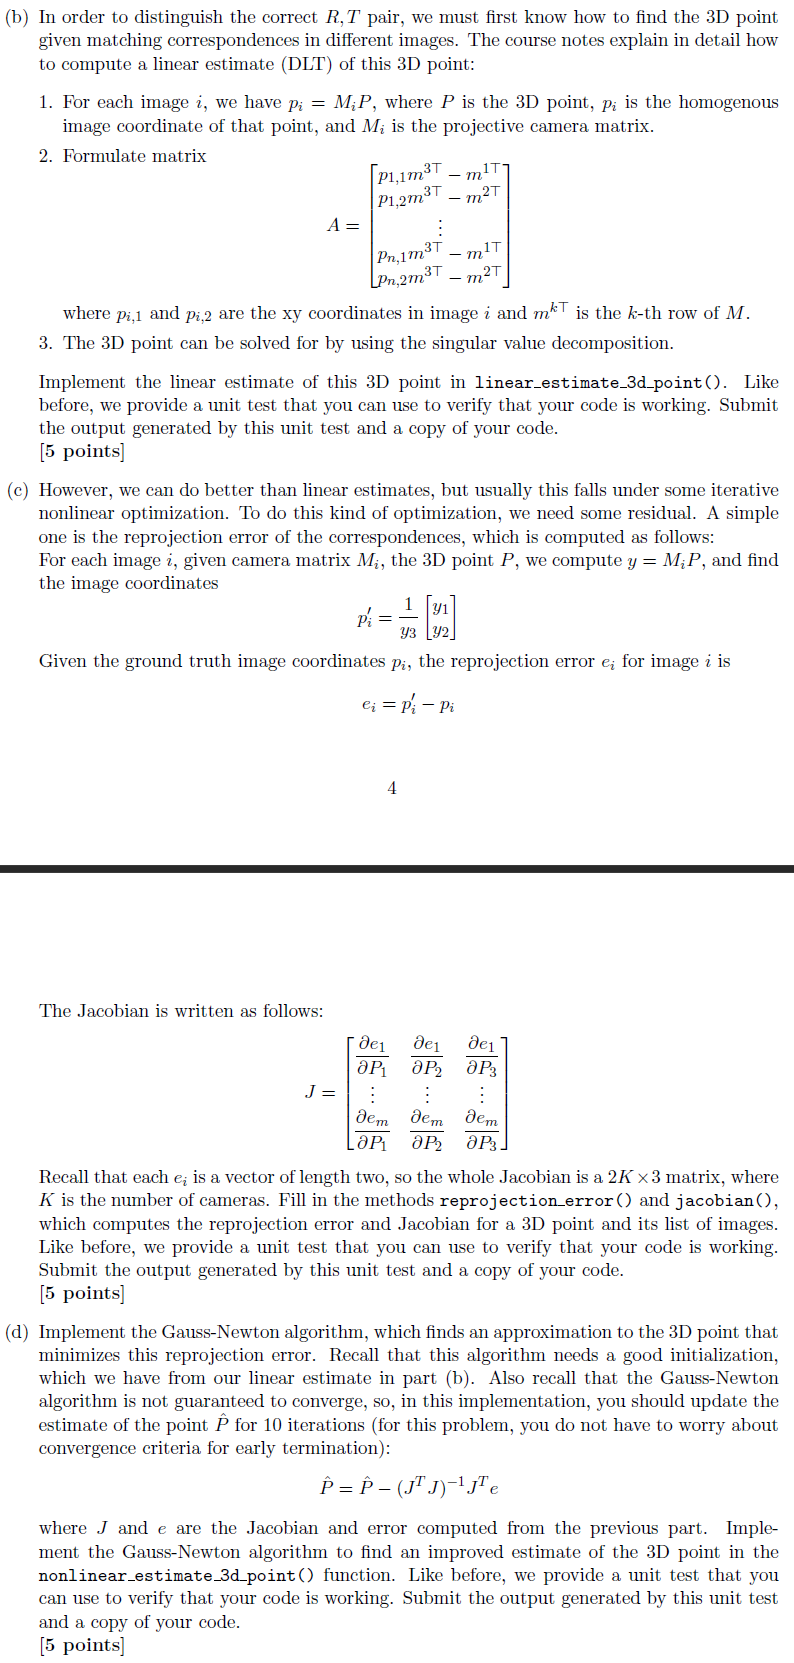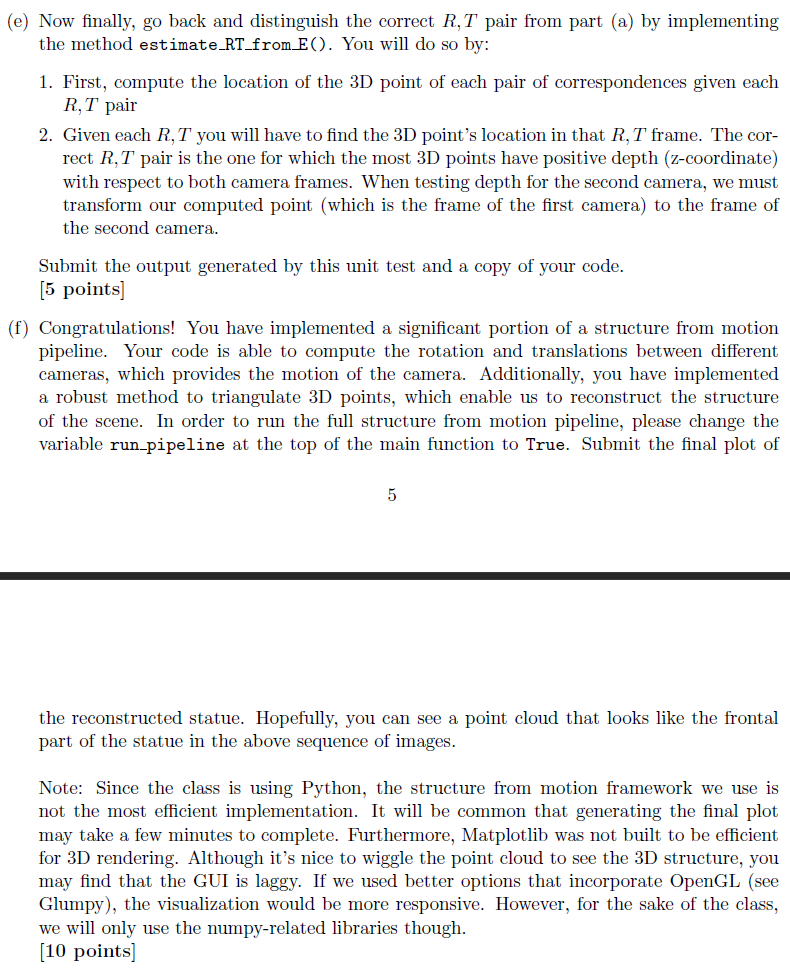